Прочтём данные из файлов с результатами A/B-тестирования:

In [1]:
import pandas as pd

In [2]:
orders = pd.read_csv('datasets/orders.csv', parse_dates=['date'])

In [3]:
visitors = pd.read_csv('datasets/visitors.csv', parse_dates=['date'])

In [4]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [5]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [6]:
def cumulate_column(df, column):
    grouped_by_a = df[df['group'] == 'A'][column].cumsum()
    grouped_by_b = df[df['group'] == 'B'][column].cumsum()
    cumulated = pd.concat([grouped_by_a, grouped_by_b]).reset_index()
    cumulated.sort_values(by='index', inplace=True)
    return cumulated.set_index('index')

In [7]:
visitors_aggregated = visitors.groupby(['date','group'], as_index=False).agg({'date' : 'max',
                                                                              'group' : 'max',
                                                                              'visitors' : 'sum'}, axis=1)

In [8]:
orders_aggregated = orders.groupby(['date','group'], as_index=False).agg({'date' : 'max',
                                                                          'group' : 'max',
                                                                          'transactionId' : 'nunique',
                                                                          'visitorId' : 'nunique',
                                                                          'revenue' : 'sum'}, axis=1)

In [9]:
visitors_aggregated

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,619
3,2019-08-02,B,581
4,2019-08-03,A,507
...,...,...,...
57,2019-08-29,B,531
58,2019-08-30,A,490
59,2019-08-30,B,490
60,2019-08-31,A,699


In [10]:
orders_aggregated

,date,group,transactionId,visitorId,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,20,19,93822
3,2019-08-02,B,24,23,165531
4,2019-08-03,A,24,24,112473
...,...,...,...,...,...
57,2019-08-29,B,20,20,231130
58,2019-08-30,A,11,10,86460
59,2019-08-30,B,24,24,215233
60,2019-08-31,A,12,12,61833


In [11]:
cumulate_column(visitors_aggregated, 'visitors')

,visitors
index,
0,719
1,713
2,1338
3,1294
4,1845
...,...
57,17708
58,18037
59,18198


In [12]:
cumulate_column(orders_aggregated, 'revenue')

,revenue
index,
0,148579
1,101217
2,242401
3,266748
4,354874
...,...
57,5559398
58,4022970
59,5774631


In [13]:
visitors_aggregated['visitors'] = cumulate_column(visitors_aggregated, 'visitors')
orders_aggregated['transactionId'] = cumulate_column(orders_aggregated, 'transactionId')
orders_aggregated['visitorId'] = cumulate_column(orders_aggregated, 'visitorId')

In [14]:
visitors_aggregated

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845
...,...,...,...
57,2019-08-29,B,17708
58,2019-08-30,A,18037
59,2019-08-30,B,18198
60,2019-08-31,A,18736


In [15]:
orders_aggregated

,date,group,transactionId,visitorId,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,39,93822
3,2019-08-02,B,45,43,165531
4,2019-08-03,A,68,63,112473
...,...,...,...,...,...
57,2019-08-29,B,596,584,231130
58,2019-08-30,A,545,531,86460
59,2019-08-30,B,620,608,215233
60,2019-08-31,A,557,543,61833


In [16]:
cumulativeData = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(11)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,39,93822,1338
3,2019-08-02,B,45,43,165531,1294
4,2019-08-03,A,68,63,112473,1845
5,2019-08-03,B,61,59,114248,1803
6,2019-08-04,A,84,78,70825,2562
7,2019-08-04,B,78,75,108571,2573
8,2019-08-05,A,109,103,124218,3318
9,2019-08-05,B,101,98,92428,3280


In [17]:
cumulativeData = orders_aggregated.merge(visitors_aggregated)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,39,93822,1338
3,2019-08-02,B,45,43,165531,1294
4,2019-08-03,A,68,63,112473,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,584,231130,17708
58,2019-08-30,A,545,531,86460,18037
59,2019-08-30,B,620,608,215233,18198
60,2019-08-31,A,557,543,61833,18736


In [18]:
visitors[visitors['date'] == '2019-08-05']

,date,group,visitors
4,2019-08-05,A,756
35,2019-08-05,B,707


In [19]:
orders[orders['date'] == '2019-08-05'].count()

transactionId    48
visitorId        48
date             48
revenue          48
group            48
dtype: int64

In [20]:
temp = orders[orders['date'] == '2019-08-05']

In [21]:
temp.groupby(['date'], as_index=False).agg({'date' : 'max',
                                            'group' : 'max',
                                            'transactionId' : 'nunique',
                                            'visitorId' : 'nunique',
                                            'revenue' : 'sum'}, axis=1)

,date,group,transactionId,visitorId,revenue
0,2019-08-05,B,48,47,216646


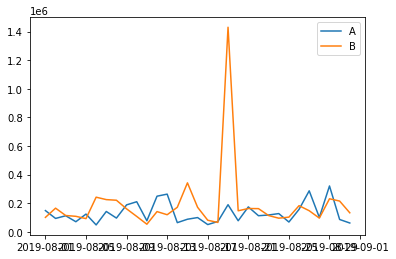

In [22]:
import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

In [23]:
from solver.ab_reporter import ABReporter

In [24]:
example = ABReporter('datasets/visitors.csv', 'datasets/orders.csv')

In [25]:
cumulated = example.grouped_summary()

In [62]:
def plot_cumulative_metrics():
    """Функция для визуализации кумулятивных метрик."""
    plt.figure(figsize=(25, 10))
    plt.style.use('seaborn-darkgrid')
    
    columns_to_pick = ['date','revenue', 'orders', 'conversion']
    revenue_a = cumulated.query('group == "A"')[columns_to_pick]
    revenue_b = cumulated.query('group == "B"')[columns_to_pick]
    merged_revenues = revenue_a.merge(revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
    

    # кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(revenue_a['date'].dt.date, revenue_a['revenue'], label='A')
    plt.plot(revenue_b['date'].dt.date, revenue_b['revenue'], label='B')
    ax1.set_xticks(revenue_a['date'].dt.date[::7])
    ax1.set_xticklabels(revenue_a['date'].dt.date[::7])
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    
    ax2 = plt.subplot(2, 3, 2)    
    plt.plot(revenue_a['date'], revenue_a['revenue']/revenue_a['orders'], label='A')
    plt.plot(revenue_b['date'], revenue_b['revenue']/revenue_b['orders'], label='B')
    plt.legend() 
    
    ax3 = plt.subplot(2, 3, 3)   
    plt.plot(merged_revenues['date'], (merged_revenues['revenueB']/merged_revenues['ordersB'])/(merged_revenues['revenueA']/merged_revenues['ordersA'])-1)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.grid()

    ax4 = plt.subplot(2, 3, 4)
    plt.plot(revenue_a['date'], revenue_a['conversion'], label='A')
    plt.plot(revenue_b['date'], revenue_b['conversion'], label='B')
    plt.legend()
    
    ax5 = plt.subplot(2, 3, 5)
    plt.plot(merged_revenues['date'], merged_revenues['conversionB']/merged_revenues['conversionA']-1)
    plt.legend()
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=-0.1, color='grey', linestyle='--')
    plt.title('Относительный прирост конверсии группы B относительно группы A')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


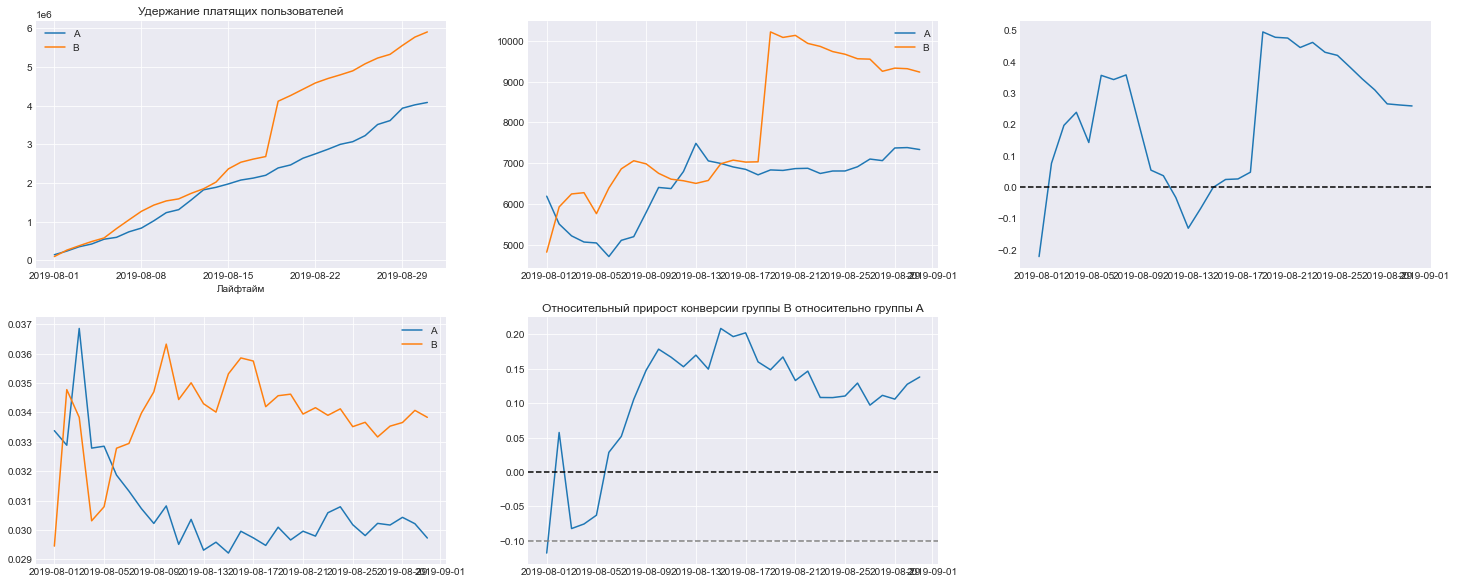

In [63]:
plot_cumulative_metrics()

In [ ]:
cumulated.groupby(['group', 'date'])['revenue'].sum().plot()

In [ ]:
columns_to_pick = ['date','revenue', 'orders']
conversion_hist = cumulated[columns_to_pick]

In [ ]:
cumulated

In [ ]:
cumulated[['revenue']].plot()

In [ ]:
columns = [name for name in conversion_hist.index.names
           if name not in ['date']]
filtered_data = conversion_hist.pivot_table(
    index='date')

In [ ]:
filtered_data

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:


In [ ]:
df = visitors.groupby(['date','group'], as_index=False).agg({'date' : 'max',
                                                        'group' : 'max',
                                                        'visitors' : 'sum'}, axis=1).sort_values(by=['date','group'])

In [ ]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))